# RESOLVE01 学習データの生成・DNNモデルの構築
松本(2020)が再現できる範囲

In [1]:
%pwd # ~/ch01_generate_datasetsならOK

'/Users/quetzal/GL/geophysics/Repos/DLXEMAir/environment/JupyterNB'

## 1.1 データ生成

- import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from dlxem import emexecutor as em
from dlxem import networks, forward

Using TensorFlow backend.


- settings

In [14]:

config = {
    'thicks' : [10. for i in range(10)],
    'res_range' : (1e-2, 1e4),
    'height_range' : (15, 75),
    'freqs' : [382, 1822, 7970, 35920, 130100],
    'span' : 7.86,
    'to_ppm' : True,
    'add_noise' : True,
    'noise_level' : [10, 10, 20, 40, 50],
    'random_mode' : 'smooth_mix',
    'ground_char' : 'r'
}
thicks = config['thicks']
freqs = config['freqs']
span = config['span']

size = 10000
parallel_num = 8

file_tag = '20210628bresolve_'

dataset_path = '../DB/dataset/'
dsetfile_name = dataset_path + file_tag+'{}_{}.csv'.format(size, config['random_mode'])

model_path = '../CORE/'
histfile_name = model_path + 'history/' + file_tag + 'history.csv'
nnetfile_name = model_path + 'network/' + file_tag + 'network.h5'
print(span)

7.86


- run

In [15]:
if os.path.exists(dsetfile_name):
    print('Datasets already exist')
else:
    resolve = em.Resolve1D(**config)
    data = resolve.multi_process(size, parallel_num)

    df = pd.DataFrame(data)
    df.to_csv(dsetfile_name, header=None, index=False)
    print("-> /" + dsetfile_name)

-> /../DB/dataset/20210628bresolve_10000_smooth_mix.csv


## 1.2 モデル学習

In [16]:
#全体読み込み
df = pd.read_csv(dsetfile_name, header=None)

#分割
x = df.iloc[:, :11].values
y = df.iloc[:, 11:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()
#x正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [17]:
if os.path.exists(nnetfile_name):
    print('The Specified Neural Network Model Already Exists.')
    network = load_model(nnetfile_name)
    hist_df = pd.read_csv(histfile_name)
else:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=64, epochs=100, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_name)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_name)

Train on 9800 samples, validate on 100 samples
Epoch 1/100
 - 8s - loss: 0.7073 - val_loss: 0.3817
Epoch 2/100
 - 7s - loss: 0.4691 - val_loss: 0.3788
Epoch 3/100
 - 7s - loss: 0.4087 - val_loss: 0.2781
Epoch 4/100
 - 7s - loss: 0.3744 - val_loss: 0.2477
Epoch 5/100
 - 7s - loss: 0.3551 - val_loss: 0.3000
Epoch 6/100
 - 7s - loss: 0.3271 - val_loss: 0.3657
Epoch 7/100
 - 7s - loss: 0.3133 - val_loss: 0.2090
Epoch 8/100
 - 7s - loss: 0.2968 - val_loss: 0.2026
Epoch 9/100
 - 7s - loss: 0.2819 - val_loss: 0.1710
Epoch 10/100
 - 7s - loss: 0.2747 - val_loss: 0.1687
Epoch 11/100
 - 7s - loss: 0.2632 - val_loss: 0.1774
Epoch 12/100
 - 7s - loss: 0.2453 - val_loss: 0.1412
Epoch 13/100
 - 7s - loss: 0.2374 - val_loss: 0.1481
Epoch 14/100
 - 7s - loss: 0.2291 - val_loss: 0.1480
Epoch 15/100
 - 7s - loss: 0.2271 - val_loss: 0.1285
Epoch 16/100
 - 7s - loss: 0.2223 - val_loss: 0.1664
Epoch 17/100
 - 7s - loss: 0.2159 - val_loss: 0.1446
Epoch 18/100
 - 7s - loss: 0.2170 - val_loss: 0.1481
Epoch 19

# 評価・テスト

## 学習過程

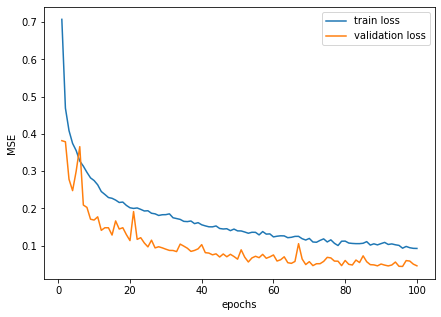

In [18]:
epochs = 100
epochs = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(epochs, loss, label='train loss')
ax.plot(epochs, val_mse, label='validation loss')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

# MSE分布と累積度数

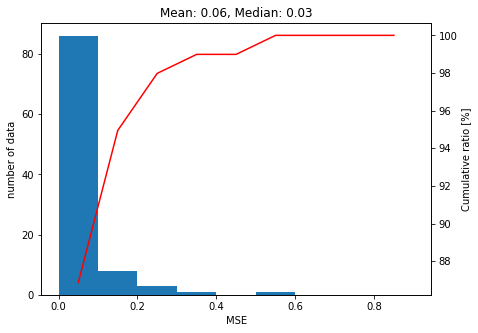

In [147]:
terr = (y_test - network.predict(x_test))**2
res_mse = np.array([k.mean() for k in terr])

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
bins = [.1*(i) for i in range(10)] #適宜調整
n, bins, patches = ax.hist(res_mse, bins=bins)
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax.set_xlabel('MSE')
ax.set_ylabel('number of data')
mean = np.mean(res_mse)
median = np.median(res_mse)
ax.set_title('Mean: {mean:.2f}, Median: {median:.2f}'.format(mean=mean, median=median))

# 第2軸のプロット
bx = ax.twinx()
lines = bx.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
bx.set_ylabel('Cumulative ratio [%]')
print('')

# テスト

In [187]:
def resistivity_step(ax, thicks, pred_res, true_res, log_depth=False):
    thicks_add = [*thicks, thicks[-1]]
    #thicks_add = thicks
    pr = [*pred_res, pred_res[-1]]
    tr = [*true_res, true_res[-1]]
    depth = [0, *np.cumsum(thicks_add)]
    ax.step(pr, depth, label='predict')
    ax.step(tr, depth, label='label')
    ax.set_xscale('log')
    ax.set_xlim(1e-2, 1e6)
    ax.set_xlabel('resistivity ${\mathrm{(\Omega \cdot m)}}$')
    ax.set_ylim(0, depth[-1])
    ax.set_ylabel('depth[m]')
    if log_depth:
        ax.set_yscale('log')
        ax.set_ylim(1e-3, depth[-1])
    ax.invert_yaxis()
    ax.legend()
    ax.set_title('${ρ_{\mathrm{pred}}}$ and ${ρ_{\mathrm{true}}}$')

def resistivity_error_step(ax, thicks, pred_res, true_res, log_depth=False):
    thicks_add = [*thicks, thicks[-1]]
    #thicks_add = thicks
    pr = np.array([*pred_res, pred_res[-1]])
    tr = np.array([*true_res, true_res[-1]])
    depth = [0, *np.cumsum(thicks_add)]
    abs_err = abs(pr-tr)

    ax.step(abs_err, depth)
    low = 10 ** (int(np.log10(min(abs_err)))-2)
    high = max(abs_err) * 1.1
    ax.set_xlim(-high*0.05, high)
    #ax.set_xscale('log')
    ax.set_xlabel('Absolute Error ${\mathrm{(\Omega \cdot m)}}$')
    ax.set_ylim(0, depth[-1])
    ax.set_ylabel('depth[m]')
    if log_depth:
        ax.set_yscale('log')
        ax.set_ylim(1e-3, depth[-1])
    ax.invert_yaxis()
    ax.set_title('Absolute Error between ${ρ_{\mathrm{pred}}}$ and ${ρ_{\mathrm{true}}}$')
    

def emfield_imag(ax, freqs, cfreqs, pred_emf, true_emf, pred_cemf, true_cemf, orig_emf):
    cfreqsize = len(cfreqs)
    freqsize = len(freqs)
    ax.plot(cfreqs, pred_cemf[cfreqsize:], 'C0', linewidth=0.5, label='predicted')
    ax.plot(cfreqs, -pred_cemf[cfreqsize:], 'C0--', linewidth=0.5)
    ax.plot(freqs, pred_emf[freqsize:], 'C0', marker='+', linewidth=0)
    ax.plot(freqs, -pred_emf[freqsize:], 'C0', marker='+', linewidth=0)
    ax.plot(cfreqs, true_cemf[cfreqsize:], 'C1', linewidth=0.5, label='denoised')
    ax.plot(cfreqs, -true_cemf[cfreqsize:], 'C1--', linewidth=0.5)
    ax.plot(freqs, true_emf[freqsize:], 'C1', marker='.', linewidth=0)
    ax.plot(freqs, -true_emf[freqsize:], 'C1', marker='.', linewidth=0)
    ax.plot(freqs, orig_emf[freqsize:], 'C2', marker='x', linewidth=0, label='original noised')
    ax.plot(freqs, -orig_emf[freqsize:], 'C2', marker='x', linewidth=0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Frequecy (Hz)')
    ax.set_ylabel('Secondary field $h_z$ (ppm)')
    ax.set_title('Imaginary Part')

def emfield_real(ax, freqs, cfreqs, pred_emf, true_emf, pred_cemf, true_cemf, orig_emf):
    cfreqsize = len(cfreqs)
    freqsize = len(freqs)
    ax.plot(cfreqs, pred_cemf[:cfreqsize], 'C0', linewidth=0.5, label='predicted')
    ax.plot(cfreqs, -pred_cemf[:cfreqsize], 'C0--', linewidth=0.5)
    ax.plot(freqs, pred_emf[:freqsize], 'C0', marker='+', linewidth=0)
    ax.plot(freqs, -pred_emf[:freqsize], 'C0', marker='+', linewidth=0)
    ax.plot(cfreqs, true_cemf[:cfreqsize], 'C1', linewidth=0.5, label='denoised')
    ax.plot(cfreqs, -true_cemf[:cfreqsize], 'C1--', linewidth=0.5)
    ax.plot(freqs, true_emf[:freqsize], 'C1', marker='.', linewidth=0)
    ax.plot(freqs, -true_emf[:freqsize], 'C1', marker='.', linewidth=0)
    ax.plot(freqs, orig_emf[:freqsize], 'C2', marker='x', linewidth=0, label='original noised')
    ax.plot(freqs, -orig_emf[:freqsize], 'C2', marker='x', linewidth=0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Frequecy (Hz)')
    ax.set_ylabel('Secondary field $h_z$ (ppm)')
    ax.set_title('Real Part')

def emfield_error(ax1, ax2, freqs, cfreqs, pred_emf, true_emf, pred_cemf, true_cemf, orig_emf):
    cfreqsize = len(cfreqs)
    freqsize = len(freqs)
    emf_err = abs(pred_emf - true_emf) / abs(true_emf) * 100
    cemf_err = (pred_cemf - true_cemf) / abs(true_cemf) * 100
    oemf_err = abs(pred_emf - orig_emf) / abs(orig_emf) * 100

    ax1.plot(cfreqs, cemf_err[:cfreqsize], 'C1', label='vs denoized')
    ax1.plot(freqs, emf_err[:freqsize], 'C1', marker='.', linewidth=0)
    ax1.plot(cfreqs, -cemf_err[:cfreqsize], 'C1--')
    ax1.plot(freqs, oemf_err[:freqsize], 'C2', marker='x', linewidth=0, label='vs original noised')
    
    ax2.plot(cfreqs, cemf_err[cfreqsize:], 'C1', label='vs denoized')
    ax2.plot(freqs, emf_err[freqsize:], 'C1', marker='.', linewidth=0)
    ax2.plot(cfreqs, -cemf_err[cfreqsize:], 'C1--')
    ax2.plot(freqs, oemf_err[freqsize:], 'C2', marker='x', linewidth=0, label='vs original noised')

    for ax in [ax1, ax2]:
        ax.set_xscale('log')
        ax.set_ylim(-0.1,100)
        ax.set_xlabel('Frequecy (Hz)')
        ax.set_ylabel('Relative error (%)')
        ax.legend()
    
    ax1.set_title('')
    ax2.set_title('')



def sample_summary_plot(thicks, pred_res, true_res, height, span, freqs, cfreq_size, orig_emf, ppm=True):
    fig = plt.figure(figsize=(14, 21), dpi=100)
    ax1 = fig.add_subplot(3,2,1)
    ax2 = fig.add_subplot(3,2,2)
    ax3 = fig.add_subplot(3,2,3)
    ax4 = fig.add_subplot(3,2,4)
    ax5 = fig.add_subplot(3,2,5)
    ax6 = fig.add_subplot(3,2,6)

    resistivity_step(ax1, thicks, pred_res, true_res, log_depth=False)
    resistivity_error_step(ax2, thicks, pred_res, true_res, log_depth=False)

    cfreq_min = np.log10(min(freqs)*0.1)
    cfreq_max = np.log10(max(freqs)*10)
    cfreqs = np.logspace(cfreq_min, cfreq_max, cfreq_size)
    freq_size = len(freqs)
    if not ppm:
        true_emf = forward.resolve(thicks, true_res, height, span, freqs, add_noise=False, to_ppm=False)
        pred_emf = forward.resolve(thicks, pred_res, height, span, freqs, add_noise=False, to_ppm=False)
        true_cemf = forward.resolve(thicks, true_res, height, span, cfreqs, add_noise=False, to_ppm=False)
        pred_cemf = forward.resolve(thicks, pred_res, height, span, cfreqs, add_noise=False, to_ppm=False)

        primary_field = -1 / (4 * np.pi * span ** 3)
        real_ppm = orig_emf[:freq_size]
        imag_ppm = orig_emf[freq_size:]
        raw_real = real_ppm * primary_field * 1e-6 + primary_field
        raw_imag = imag_ppm * primary_field * 1e-6
        orig_emf = np.hstack([raw_real, raw_imag])

    else:
        true_emf = forward.resolve(thicks, true_res, height, span, freqs, add_noise=False)
        pred_emf = forward.resolve(thicks, pred_res, height, span, freqs, add_noise=False)
        true_cemf = forward.resolve(thicks, true_res, height, span, cfreqs, add_noise=False)
        pred_cemf = forward.resolve(thicks, pred_res, height, span, cfreqs, add_noise=False)

    emfield_real(ax3, freqs, cfreqs, pred_emf, true_emf, pred_cemf, true_cemf, orig_emf)
    emfield_imag(ax5, freqs, cfreqs, pred_emf, true_emf, pred_cemf, true_cemf, orig_emf)
    emfield_error(ax4, ax6, freqs, cfreqs, pred_emf, true_emf, pred_cemf, true_cemf, orig_emf)

    return fig


32


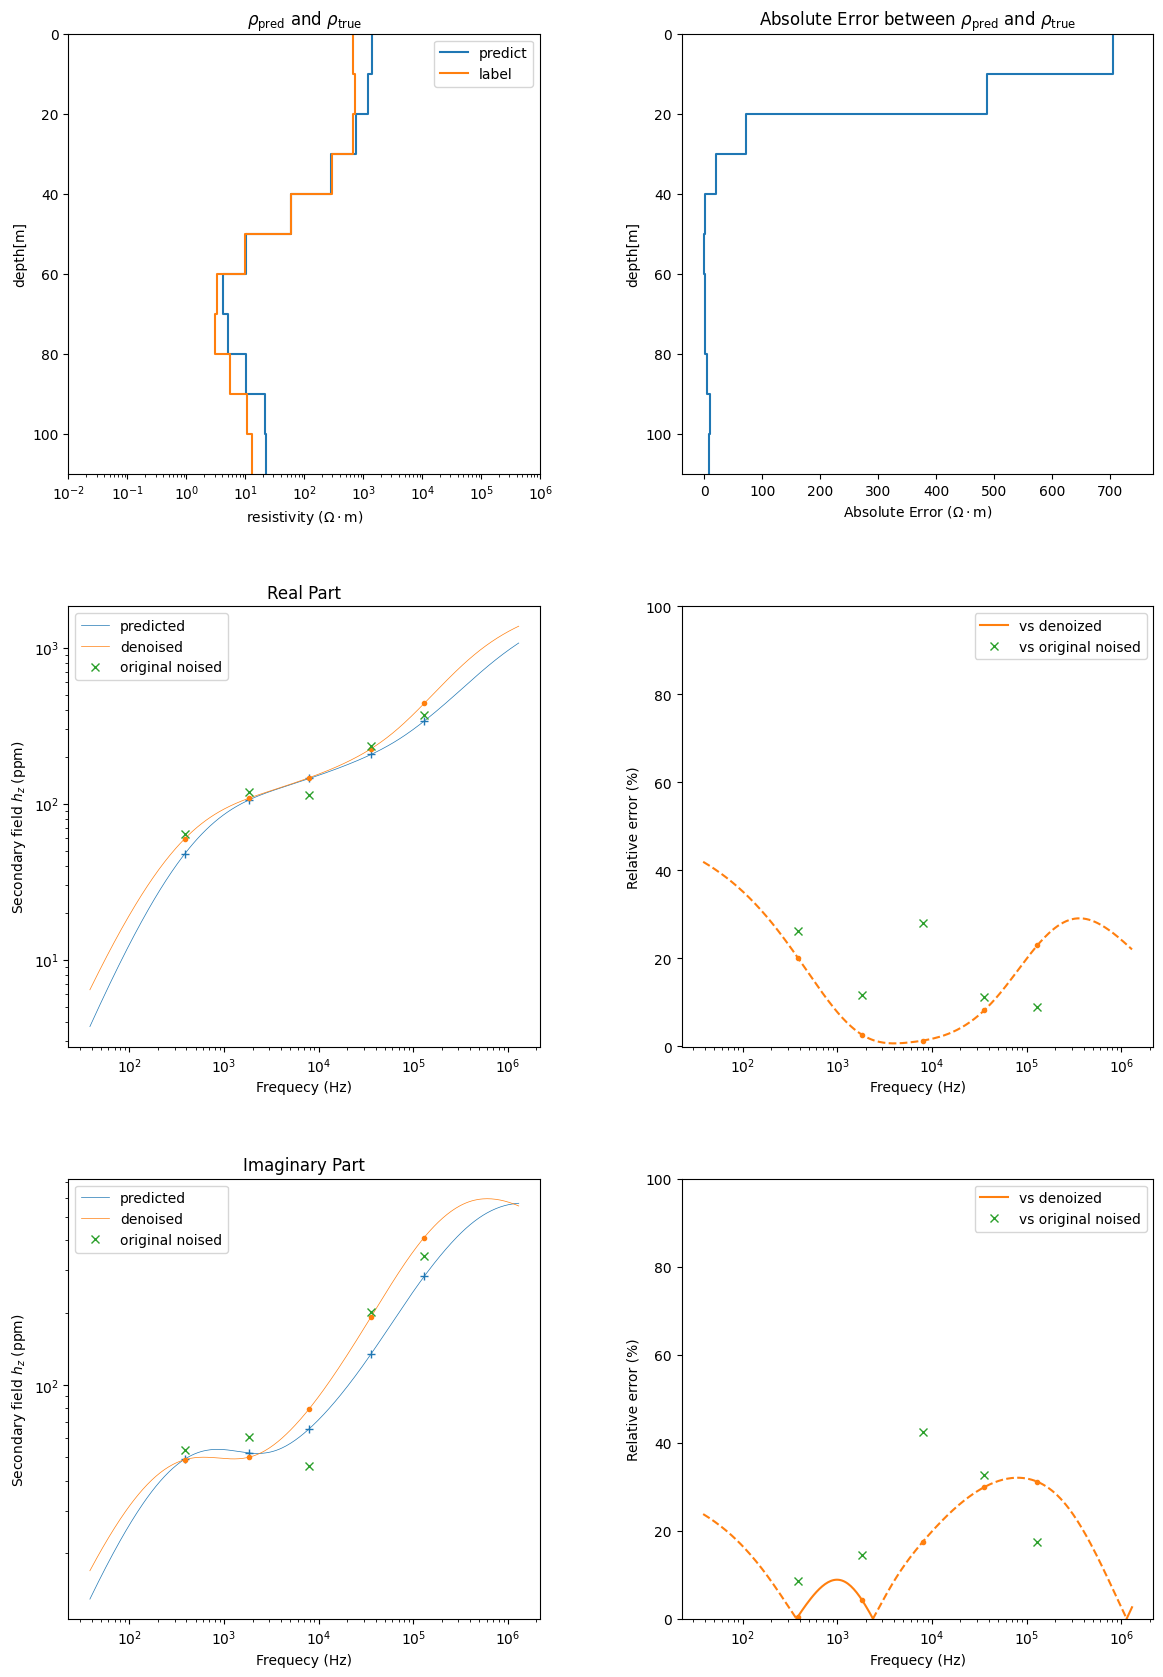

In [198]:
true_res = 10 ** y_test
pred_res = 10 ** network.predict(x_test)
orig_emf = x_test_org[:, :10]
height = x_test_org[:, 10]

test_data_size = len(y_test)
index = np.random.randint(0, test_data_size, 1)[0]

true_res = true_res[index]
pred_res = pred_res[index]
height = height[index]
orig_emf = orig_emf[index]

cfreq_size = 300
print(index)

fig = sample_summary_plot(thicks, pred_res, true_res, height, span, freqs, cfreq_size, orig_emf)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

In [66]:
print(index)

[1]


In [71]:
int(3.6)

3

In [72]:
int(3.2)

3